<a href="https://colab.research.google.com/github/aidannguyen23/Youtube-Sentiment-Analysis/blob/main/YoutubeCommentsSentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import pandas as pd
import numpy as np

## Output as Pandas Dataframe

In [ ]:
import googleapiclient.discovery
import pandas as pd

def get_youtube_comments_df(video_id, max_results=100):
    api_service_name = "youtube"
    api_version = "v3"
    DEVELOPER_KEY = "**zaSyCAfQHTruZdm5wqpyQRuAn_Hs3LsugNMYw"

    youtube = googleapiclient.discovery.build(
        api_service_name, api_version, developerKey=DEVELOPER_KEY)

    request = youtube.commentThreads().list(
        part="snippet",
        videoId=video_id,
        maxResults=max_results
    )
    response = request.execute()

    comments_text = []

    for item in response['items']:
        text_display = item['snippet']['topLevelComment']['snippet']['textDisplay']
        comments_text.append(text_display)

    df = pd.DataFrame(comments_text, columns=['text'])
    return df

# Example usage:
video_id = "_9yhDpVUK3Q"
df = get_youtube_comments_df(video_id, max_results=100)
print(df.head())


                                                text
0  Let&#39;s gather &#39;round the campfire, and ...
1                Squidward dropped some bars in this
2  It’s better in Hebrew <a href="https://youtu.b...
3  I used to play this video for my late cousin/b...
4  Patrick looks like he was about to have a stro...


## 2. Clean the comment section

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Assuming df contains the DataFrame with the 'text' column

# Convert 'text' column to lowercase
df['text'] = df['text'].str.lower()

# Remove special characters, punctuation, and URLs
df['text'] = df['text'].apply(lambda x: re.sub(r'http\S+', '', x))  # Remove URLs
df['text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))  # Remove special characters

# Display the cleaned 'text' column
print(df['text'])


## 3. Instantiate Model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('lxyuan/distilbert-base-multilingual-cased-sentiments-student')
model = AutoModelForSequenceClassification.from_pretrained('lxyuan/distilbert-base-multilingual-cased-sentiments-student')

## 4. Load Comments into DataFrame and Score

In [ ]:
def sentiment_score(comment):
  tokens = tokenizer.encode(comment, return_tensors='pt')
  result = model(tokens)
  return int(torch.argmax(result.logits))

In [ ]:
df['sentiment'] = df['text'].apply(lambda x: sentiment_score(x[:512]))

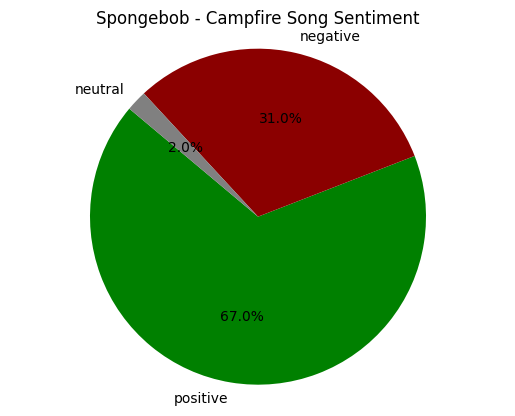

In [ ]:
from matplotlib import pyplot as plt

# Count the frequency of values in the 'sentiment' column
frequency = df['sentiment'].value_counts().to_dict()

# Map sentiment values to labels
sentiment_labels = {2: 'negative', 1: 'neutral', 0: 'positive'}

# Map sentiment values to labels in the frequency dictionary
frequency_labeled = {sentiment_labels[key]: value for key, value in frequency.items()}

# Data for the pie chart
labels = list(frequency_labeled.keys())
sizes = list(frequency_labeled.values())

# Creating the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['green', '#8B0000', 'gray'], startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Spongebob - Campfire Song Sentiment')
plt.show()
